## THINGS TO DO

##### Add Language Constraints
##### Add Capacity Constraints

In [1]:
from gurobipy import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import shapefile as shp
from collections import defaultdict

In [2]:
UpdateMode=1

#### copy dictionnary example

In [3]:
dict1 = {"key1": "value1", "key2": "value2"}
dict2 = dict1.copy()


In [4]:
print(dict1)
print(dict2)

{'key1': 'value1', 'key2': 'value2'}
{'key1': 'value1', 'key2': 'value2'}


In [5]:
dict1["key2"] = "WHY?!"
dict1

{'key1': 'value1', 'key2': 'WHY?!'}

In [6]:
dict2

{'key1': 'value1', 'key2': 'value2'}

In [7]:
dict2

{'key1': 'value1', 'key2': 'value2'}

### Set Parameters

In [8]:
M = 10000
maxOpenD = 50
maxOpenA = 20
maxDistance = 10000

maxDist_D = 150
maxDist_A = 350

#maxPopD- max capacity of each district court
#maxPopA - max capacity of each appeals court

#xS,yS 
#xD,yD
#xA,yA

#langS
#langD
#langA


#param d{i in Settlements,j in DistrictCourts} 
#	:= sqrt( (xS[i]-xD[j])^2 + (yS[i]-yD[j])^2); #distance between settlement and district court
#param a{i in Settlements,k in AppealsCourts} 
#	:= sqrt( (xA[k]-xS[i])^2 + (yA[k]-yS[i])^2); #distance between district court and appeals court	

### Extract Data

In [9]:
#Get Settlement List
#Settlements = pd.read_csv("afg_ppl_settlement_pnt.csv",sep=",")
Settlements=pd.read_csv("prov_code_3.csv",sep=",")
Settlements = Settlements[["OBJECTID","LAT_Y","LON_X"]]
#Settlements=Settlements[[0,10,11]]
S = Settlements.shape[0]
Settlement_List = Settlements['OBJECTID'].tolist()

#Get District Court List
Districts = pd.read_csv("District_Courts.csv",sep=",")
Districts = Districts[[1,4,5]]
D = Districts.shape[0]
District_List = Districts['DIST_CODE'].tolist()

#Get Appeals Court List
Appeals = pd.read_csv("Appeals_Courts.csv",sep=",")
Appeals = Appeals[[1,4,5]]
A = Appeals.shape[0]
Appeals_List = Appeals['PROV_CODE'].tolist()

#### Create Data Subset for Settlements

#### ------------------------------------------------

In [10]:
Settlements = Settlements.sample(frac = 0.01, replace = False)
S = Settlements.shape[0]
Settlement_List = Settlements['OBJECTID'].tolist()

####  ------------------------------------------------

In [11]:
#Create Dictionaries
Settlement_Dict = Settlements.set_index('OBJECTID').T.to_dict('list')
District_Dict = Districts.set_index('DIST_CODE').T.to_dict('list')
Appeals_Dict = Appeals.set_index('PROV_CODE').T.to_dict('list')

In [12]:
#Create Dictionaries for District Courthouse Distances

Dist_D = {}

R = 6371e3


for d in District_List:
    d_lon = District_Dict[d][0]
    d_lat = District_Dict[d][1]
    φ2 = np.radians(d_lat)


    for s in Settlement_List:
        s_lon = Settlement_Dict[s][1]
        s_lat = Settlement_Dict[s][0]
        φ1 = np.radians(s_lat)
        
        #Distance to District Court
        Δφ = np.radians(d_lat - s_lat)
        Δλ = np.radians(d_lon - s_lon)
        a = np.sin(Δφ/2) * np.sin(Δφ/2) + np.cos(φ1) * np.cos(φ2) * np.sin(Δλ/2) * np.sin(Δλ/2)
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
        
        Dist_D[s,d] = (R * c)/1000
    

In [13]:
#Create Dictionaries for Appeals Courthouse Distances

Dist_A = {}

R = 6371e3

for a in Appeals_List:
    a_lon = Appeals_Dict[a][0]
    a_lat = Appeals_Dict[a][1]
    φ3 = np.radians(a_lat)

    for s in Settlement_List:
        s_lon = Settlement_Dict[s][1]
        s_lat = Settlement_Dict[s][0]
        φ1 = np.radians(s_lat)
        
        #Distance to District Court
        Δφ = np.radians(a_lat - s_lat)
        Δλ = np.radians(a_lon - s_lon)
        a1 = np.sin(Δφ/2) * np.sin(Δφ/2) + np.cos(φ1) * np.cos(φ3) * np.sin(Δλ/2) * np.sin(Δλ/2)
        c = 2 * np.arctan2(np.sqrt(a1), np.sqrt(1-a1))
        
        Dist_A[s,a] = (R * c)/1000
        
    

### Create Model

In [14]:
#Create Model
m = Model("Afghanistan")

#Suppress output
m.Params.OutputFlag = 0

### Create Variables

##### Helper function

In [15]:
# Return value of variable
def VarVal(var):
    if (type(var) == gurobipy.Var):
        val = var.X

    else:
        val = 0
    return val

##### d_ij

In [16]:
# Create d_i_j variables
d = {}
for i in Settlement_List:
    d[i] = {}
    for j in District_List:
        if Dist_D[i,j] < maxDist_D:
            d[i][j] = m.addVar(vtype=GRB.BINARY, name='d_%s_%s' % (i, j))
            d[i][j].start=10000
        else:
            d[i][j] = 0
m.update()

In [17]:
# Create d_i_j transpose dictionary 
d_t = defaultdict(dict)
for key, val in d.items():
    for subkey, subval in val.items():
        d_t[subkey][key] = subval

##### a_ik

In [18]:
 # Create a_i_k variables
a = {}
for i in Settlement_List:
    a[i] = {}
    for k in Appeals_List:
        if Dist_A[i,k] < maxDist_A:
            a[i][k] = m.addVar(vtype=GRB.BINARY, name='a_%s_%s' % (i, k))
            a[i][k].start=0
        else:
            a[i][k] = 0
m.update()

In [19]:
# Create a_i_k transpose dictionary 
a_t = defaultdict(dict)
for key, val in a.items():
    for subkey, subval in val.items():
        a_t[subkey][key] = subval

##### c_jk

In [20]:
# Create c_j_k variables
c = {}
for j in District_List:
    c[j] = {}
    for k in Appeals_List:
        c[j][k] = m.addVar(vtype=GRB.BINARY, name='c_%s_%s' % (j, k))
        c[j][k].start=0
m.update()

In [21]:
# Create c_j_k transpose dictionary 
c_t = defaultdict(dict)
for key, val in c.items():
    for subkey, subval in val.items():
        c_t[subkey][key] = subval

In [22]:
c[0][1].start=3


In [23]:
c[0][1].start

0.0

##### openD

In [24]:
#Create openD variables
openD = {}
for j in District_List:
    openD[j] = m.addVar(vtype=GRB.BINARY, name='openD_%s' % (j))
    openD[j].start = 0
m.update()

In [25]:
openD[0].start

0.0

##### openA

In [26]:
#Create openA variables
openA = {}
for k in Appeals_List:
    openA[k] = m.addVar(vtype=GRB.BINARY, name='openA_%s' % (k))
    openA[k].start=0
m.update()

### Create Constraints

##### D_ij row sums and column sums

In [27]:
#One S -> D Assignment
for i in Settlement_List:
    m.addConstr(quicksum(d[i][j] for j in d[i]) == 1)
m.update()

In [28]:
#Maximum District Courts Open
for j in District_List:
    m.addConstr(quicksum(d_t[j][i] for i in d_t[j]) <= M * openD[j])
m.update()

##### A_ik row sums and column sums

In [29]:
#One S -> A Assignment
for i in Settlement_List:
    m.addConstr(quicksum(a[i][k] for k in a[i]) == 1)
m.update()

In [30]:
#Maximum Appeals Courts Open
for k in Appeals_List:
    m.addConstr(quicksum(a_t[k][i] for i in a_t[k]) <= M * openA[k])
m.update()

#### C_jk row sums and column sums

In [31]:
#One D -> A Assignment
for j in District_List:
    m.addConstr(quicksum(c[j][k] for k in c[j]) == openD[j])
m.update()

In [32]:
#C constraints
for k in Appeals_List:
    m.addConstr(quicksum(c[j][k] for j in District_List) <= M*openA[k])
m.update()

##### Max Open Courthouse Constraints

In [33]:
m.addConstr(quicksum(openD[j] for j in District_List) <= maxOpenD)

m.update()

In [34]:
m.addConstr(quicksum(openA[k] for k in Appeals_List) <= maxOpenA)

m.update()

In [35]:
m

<gurobi.Model MIP instance Afghanistan: 890 constrs, 15582 vars, Parameter changes: LogFile=gurobi.log, OutputFlag=0>

### Set Objective Function

#### D_ij and A_ik

In [36]:
 m.setObjective(
        quicksum(   quicksum(   Dist_D[i,j]*d_t[j][i] for i in d_t[j])    for j in District_List) + \
        quicksum(   quicksum(   Dist_A[i,k]*a_t[k][i] for i in a_t[k])    for k in Appeals_List), GRB.MINIMIZE)
m.update()

### Optimize

##### Iteratively add violated linking constraints

In [37]:
#Dual steepest edge pivoting

In [38]:
#Initiate while loop
violated_c = 1

while (violated_c > 0):
    print("Optimize")
    
    m.optimize()
    
    violated_c = 0
    for i in Settlement_List:
        for j in District_List:
            for k in Appeals_List:
                #Assign vars based on 0 or gurobi.Var               
                d_val = VarVal(d[i][j])
                a_val = VarVal(a[i][k])
                c_val = VarVal(c[j][k])
                
                #Add constraints if violated
                if (d_val + a_val - c_val > 1):
                    violated_c = violated_c + 1
                    m.addConstr(d[i][j] + a[i][k] - c[j][k] <= 1)
                    
    m.update() 
"""
    for i in Settlement_List:
        for j in District_List:
            if type(d[i][j])==gurobipy.Var:
                (d[i][j]).start=(d[i][j]).X
                #print("aaaaa :",d[i][j].X)
                if d[i][j].X>0:
                    print((i,j))
                    
    for i in Settlement_List:
        for k in Appeals_List:
            if type(a[i][k])==gurobipy.Var:
                (a[i][k]).start=a[i][k].X
                if a[i][k].X>0:
                    print((i,k))
   
    print("district - appeals")

    for j in District_List:
        for k in Appeals_List:
            if type(c[j][k])==gurobipy.Var:
                (c[j][k]).start=c[j][k].X
                if c[j][k].X>0:
                    print((j,k))
"""                     
    
    #m.update() 
    

    
   
  
   
    
"""    
model.optimize();
if model.get(GRB_IntAttr_SolCount:
    cout << " ** Solution found! ** :) " << endl
else:
    cout << " ** Error ** Not solution found :( !" << endl;        
    
        
    #print("appeals")
    
    
"""
"""                
    for i in Settlement_List:
        for k in Appeals_List:
            if type(a[i][k])==gurobipy.Var:
                (a[i][k]).start=a[i][k].X
                if a[i][k].X>0:
                    print((i,k))
   
    print("district - appeals")

    for j in District_List:
        for k in Appeals_List:
            if type(c[j][k])==gurobipy.Var:
                (c[j][k]).start=c[j][k].X
                if c[j][k].X>0:
                    print((j,k))
"""
    
"""
    
     
   # m.update()
"""  
"""  
def mycallback(m, where):
    if where == GRB.Callback.MIPSOL:
        sol = m.cbGetSolution([m._vars[0], m._vars[1]])
    if sol[0] + sol[1] > 1.1:
        m.cbLazy(m._vars[0] + m._vars[1] <= 1)

m._vars = m.getVars()
m.optimize(mycallback)
"""

Optimize
Optimize
Optimize


'  \ndef mycallback(m, where):\n    if where == GRB.Callback.MIPSOL:\n        sol = m.cbGetSolution([m._vars[0], m._vars[1]])\n    if sol[0] + sol[1] > 1.1:\n        m.cbLazy(m._vars[0] + m._vars[1] <= 1)\n\nm._vars = m.getVars()\nm.optimize(mycallback)\n'

In [39]:
for i in Settlement_List:
    for j in District_List:
        if type(d[i][j])==gurobipy.Var:
            (d[i][j]).start=(d[i][j]).X
            #print("aaaaa :",d[i][j].X)
            if d[i][j].X>0:
                print((i,j))
                

(40833, 201.0)
(38975, 307.0)
(40830, 201.0)
(36202, 307.0)
(35993, 310.0)
(36051, 309.0)
(39009, 307.0)
(41861, 305.0)
(39073, 303.0)
(35886, 310.0)


#Initiate while loop
violated_c = 1

while (violated_c > 0):
    print("Optimize")
    m.optimize()
    for i in Settlement_List:
        for j in District_List:
            if type(d[i][j])==gurobipy.Var:
                (d[i][j]).start=d[i][j].X
                print("aaaaa :",d[i][j].start)
                if d[i][j].X>0:
                    print((i,j))
    
    violated_c = 0
    for i in Settlement_List:
        for j in District_List:
            for k in Appeals_List:
                #Assign vars based on 0 or gurobi.Var               
                d_val = VarVal(d[i][j])
                a_val = VarVal(a[i][k])
                c_val = VarVal(c[j][k])
                
                #Add constraints if violated
                if (d_val + a_val - c_val > 1):
                    violated_c = violated_c + 1
                    m.addConstr(d[i][j] + a[i][k] - c[j][k] <= 1)
    m.update()

    for i in Settlement_List:
        for j in District_List:
            if type(d[i][j])==gurobipy.Var:
                (d[i][j]).start=d[i][j].X
                print("aaaaa :",d[i][j].X)
                if d[i][j].X>0:
                    print((i,j))
    
    print("appeals")
                
    for i in Settlement_List:
        for k in Appeals_List:
            if type(a[i][k])==gurobipy.Var:
                (a[i][k]).start=a[i][k].X
                if a[i][k].X>0:
                    print((i,k))
   
    print("district - appeals")

    for j in District_List:
        for k in Appeals_List:
            if type(c[j][k])==gurobipy.Var:
                (c[j][k]).start=c[j][k].X
                if c[j][k].X>0:
                    print((j,k))
     
   # m.update()
    
"""  
def mycallback(m, where):
    if where == GRB.Callback.MIPSOL:
        sol = m.cbGetSolution([m._vars[0], m._vars[1]])
    if sol[0] + sol[1] > 1.1:
        m.cbLazy(m._vars[0] + m._vars[1] <= 1)

m._vars = m.getVars()
m.optimize(mycallback)
"""

### Output Solution

In [40]:
m.write("out.sol")

###  Plotting

#### DOUT

In [42]:
# DOUT - District Assignments

DOUT = pd.DataFrame.from_dict({(i,j): VarVal(d[i][j]) 
                           for i in d.keys() 
                           for j in d[i].keys()},
                           orient='index')

Settlements_DOUT = [i[0] for i in DOUT.index]
Districts_DOUT = [i[1] for i in DOUT.index]

DOUT['Settlement'] = Settlements_DOUT
DOUT['DistrictCourts'] = Districts_DOUT

DOUT = DOUT[DOUT[0] == 1.0]

#### AOUT

In [43]:
#AOUT - Appeals Assignments

AOUT = pd.DataFrame.from_dict({(i,j): VarVal(a[i][j]) 
                           for i in a.keys() 
                           for j in a[i].keys()},
                           orient='index')

Settlements_AOUT = [i[0] for i in AOUT.index]
Appeals_AOUT = [i[1] for i in AOUT.index]

AOUT['Settlement'] = Settlements_AOUT
AOUT['AppealsCourts'] = Appeals_AOUT

AOUT = AOUT[AOUT[0] == 1.0]

#### COUT

In [44]:
#COUT - Appeals Assignments

COUT = pd.DataFrame.from_dict({(i,j): VarVal(c[i][j]) 
                           for i in c.keys() 
                           for j in c[i].keys()},
                           orient='index')

Districts_COUT = [i[0] for i in COUT.index]
Appeals_COUT = [i[1] for i in COUT.index]

COUT['DistrictCourts'] = Districts_COUT
COUT['AppealsCourts'] = Appeals_COUT

COUT = COUT[COUT[0] == 1.0]

#### Plot all Locations

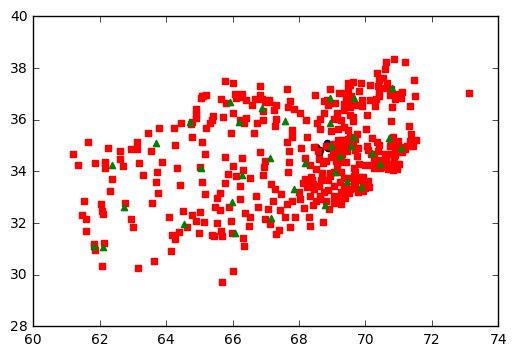

In [45]:
plt.scatter(Settlements['LON_X'],Settlements['LAT_Y'])
plt.scatter(Districts['LON_X'],Districts['LAT_Y'], color='Red', marker = 's')
plt.scatter(Appeals['LON_X'],Appeals['LAT_Y'], color='Green', marker = '^')
plt.show()

#### Plotting Assignments

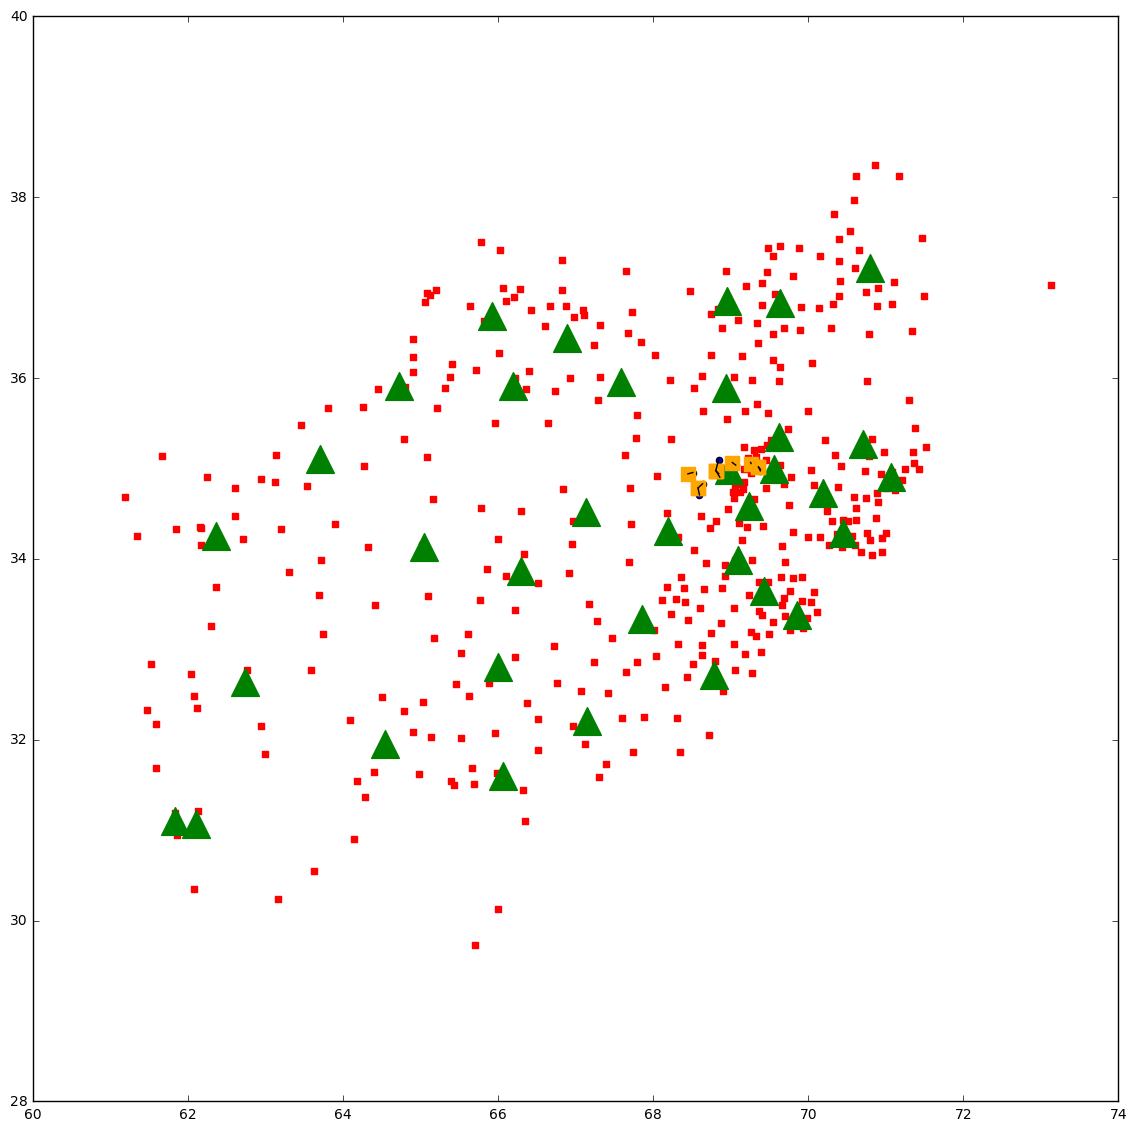

In [46]:
#Drawing Lines
plt.figure(figsize=(14,14))

#Plotting Points    
plt.scatter(Settlements['LON_X'],Settlements['LAT_Y'])
plt.scatter(Districts['LON_X'],Districts['LAT_Y'], color='Red', marker = 's',s=25)
plt.scatter(Appeals['LON_X'],Appeals['LAT_Y'], color='Green', marker = '^',s = 400)

for index,row in DOUT.iterrows():
    s = row['Settlement'] 
    d = row['DistrictCourts']
    #Get District number that Settlement is linked to
    Dist = Districts.loc[Districts['DIST_CODE'] == d]
    Sett = Settlements.loc[Settlements['OBJECTID'] == s]
    X = [Sett.iloc[0,2],Dist.iloc[0,1]]
    Y = [Sett.iloc[0,1],Dist.iloc[0,2]]
    plt.scatter(Dist.iloc[0,1],Dist.iloc[0,2], color='Orange', marker = 's',s = 100)
    plt.plot(X,Y,zorder=1, color="Black")



#axes = plt.gca()
#axes.set_xlim([68.2,70])
#axes.set_ylim([34,35.5])

plt.show()

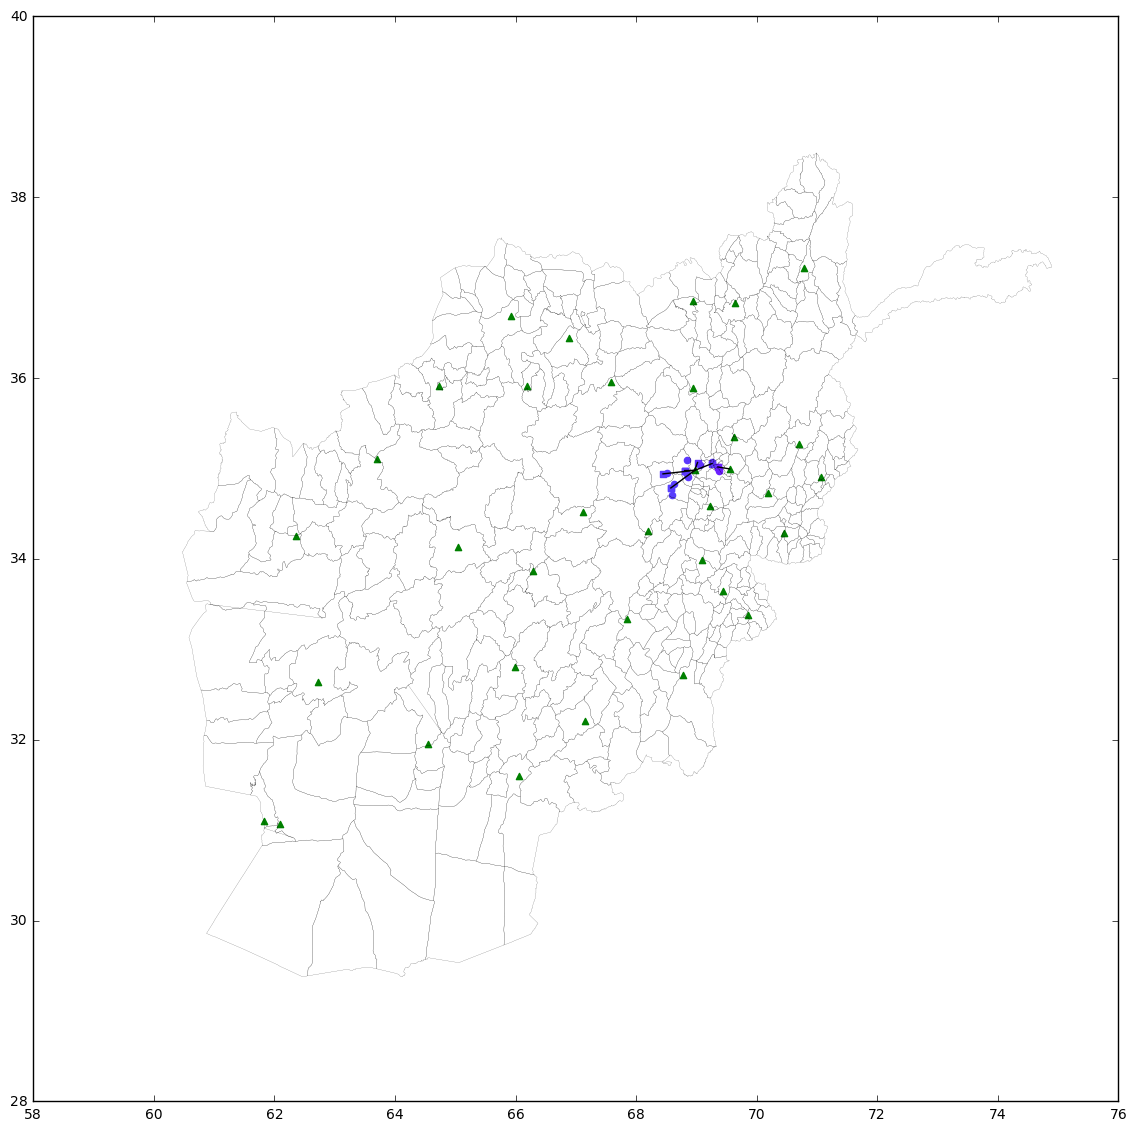

In [47]:
#Draw Lines
plt.figure(figsize=(14,14))

for index,row in COUT.iterrows():
    d = row['DistrictCourts'] 
    a = row['AppealsCourts']

    Dist = Districts.loc[Districts['DIST_CODE'] == d]
    App = Appeals.loc[Appeals['PROV_CODE'] == a]

    X = [Dist.iloc[0,1],App.iloc[0,1]]
    Y = [Dist.iloc[0,2],App.iloc[0,2]]

    plt.plot(X,Y,zorder=1, color="Black")
    
clr = cm.rainbow(np.linspace(0, 1, D))
for a in range(A):
    X = Appeals.iloc[a,1]
    Y = Appeals.iloc[a,2]
    plt.scatter(X,Y, color="Green", marker = '^')
    
for index,row in DOUT.iterrows():   
    d = row['DistrictCourts'] 
    Dist = Districts.loc[Districts['DIST_CODE'] == d]
    X = Dist.iloc[0,1]
    Y = Dist.iloc[0,2]
    c = Dist.index[0]
    plt.scatter(X,Y, color=clr[c], marker = 's')
    
for index,row in DOUT.iterrows():
    s = row['Settlement'] 
    d = row['DistrictCourts']
    #Get District number that Settlement is linked to
    Dist = Districts.loc[Districts['DIST_CODE'] == d]
    Sett = Settlements.loc[Settlements['OBJECTID'] == s]

    c = Dist.index[0]
    X = Sett.iloc[0,2]                                                     
    Y = Sett.iloc[0,1]
    plt.scatter(X,Y, color=clr[c])
          
#axes = plt.gca()
#axes.set_xlim([68.2,70])
#axes.set_ylim([34,35.5])

sf = shp.Reader("Afghanistan_Districts","rb")
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y,color='k',linewidth=0.1)
plt.show()